In [1]:
import pandas as pd
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('train_task1_latest.csv')
dft = pd.read_csv('test_task1_latest.csv')

In [4]:
df.columns

Index(['paragraph_id', 'question_id', 'paragraph', 'question', 'target'], dtype='object')

## Пересечение датасетов

In [5]:
trn_p = set(df['paragraph'])
trn_q = set(df['question'])
tst_p = set(dft['paragraph'])
tst_q = set(dft['question'])

print('Обучающая выборка')
print('\tУникальных параграфов:', len(trn_p))
print('\tУникальных вопросов:', len(trn_q))
print('Тестовая выборка')
print('\tУникальных параграфов:', len(tst_p))
print('\tУникальных вопросов:', len(tst_q))
print('Пересечение обучающей и тестовой')
print('\tПересекающихся параграфов:',len(trn_p & tst_p))
print('\tПересекающихся вопросов:',len(trn_q & tst_q))
print('Всего уникальных')
print('\tПараграфов:',len(trn_p|tst_p))
print('\tВопросов:',len(trn_q|tst_q))

Обучающая выборка
	Уникальных параграфов: 9078
	Уникальных вопросов: 38868
Тестовая выборка
	Уникальных параграфов: 1627
	Уникальных вопросов: 43340
Пересечение обучающей и тестовой
	Пересекающихся параграфов: 0
	Пересекающихся вопросов: 7
Всего уникальных
	Параграфов: 10705
	Вопросов: 82201


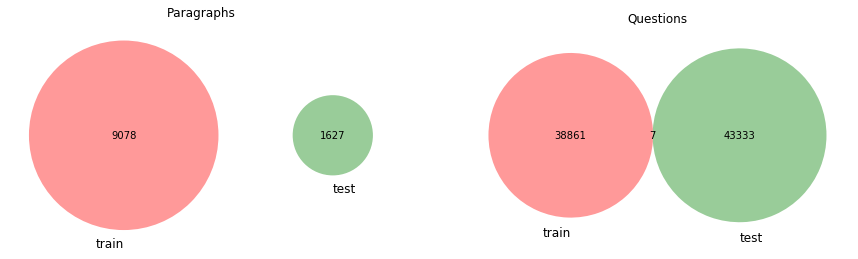

In [6]:
fig,axes = plt.subplots(1,2)
fig.set_size_inches(15,5)
axes[0].set_title('Paragraphs')
venn2([trn_p,tst_p],set_labels=['train','test'],ax=axes[0])
axes[1].set_title('Questions')
venn2([trn_q,tst_q],set_labels=['train','test'],ax=axes[1])
plt.show()

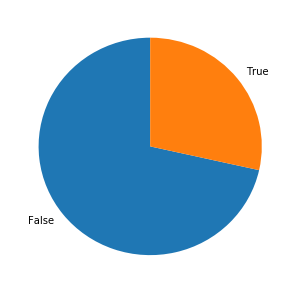

In [7]:
plt.figure(figsize=(5,5))
sizes = list(df.groupby(by='target')['target'].count())
labels = ['False','True']
plt.pie(x=sizes,labels=labels,startangle=90)
plt.show()

 ## TFIDF

In [8]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords

import string

In [13]:
texts = list(df['paragraph'])+list(df['question'])+list(dft['paragraph'])+list(dft['question'])

In [10]:
stop_words = stopwords.words('russian')
stop_words

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [11]:
wd = {}

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i.lower() for i in tokens if ( i not in string.punctuation+'—' )]
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
    stems = []
    for item in tokens:
        if item in wd.keys():
            stems.append(wd[item])
        else:
            w = SnowballStemmer(language='russian').stem(item)
            wd[item] = w
            stems.append(w)
    return stems

In [14]:
vtr = CountVectorizer(tokenizer=tokenize)
%time vtr.fit(texts)
df_p = vtr.transform(df['paragraph'])
df_q = vtr.transform(df['question'])
dft_p = vtr.transform(dft['paragraph'])
dft_q = vtr.transform(dft['question'])
print(df_p.shape,df_q.shape,dft_p.shape,dft_q.shape)

Wall time: 10min 45s
(119398, 78005) (119398, 78005) (74294, 78005) (74294, 78005)


In [15]:
from scipy import sparse
tfidf = TfidfTransformer(smooth_idf=False,sublinear_tf=False)
stk = sparse.vstack([df_p,df_q,dft_p,dft_q])
tfidf.fit(stk)

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [16]:
from sklearn.metrics.pairwise import paired_cosine_distances
dist_train = paired_cosine_distances(tfidf.transform(df_p),tfidf.transform(df_q))
dist_test = paired_cosine_distances(tfidf.transform(dft_p),tfidf.transform(dft_q))

In [17]:
df['cos_dist'] = dist_train
dft['cos_dist'] = dist_test

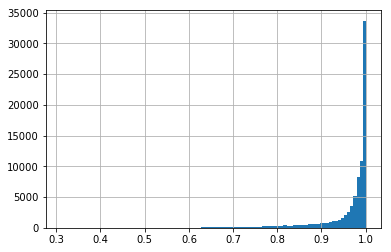

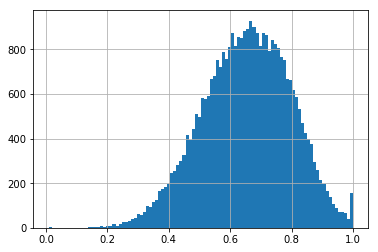

In [18]:
h = pd.DataFrame({'target':df['target'],'distance':dist_train})
h[h['target']==0]['distance'].hist(bins=100)
plt.show()
h[h['target']==1]['distance'].hist(bins=100)
plt.show()


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(class_weight={0: 1, 1: 2.5078884743073715})

lr.fit(dist_train.reshape(-1,1),df['target'].values)

print(classification_report(lr.predict(dist_train.reshape(-1,1)),df['target']))

             precision    recall  f1-score   support

        0.0       0.93      0.96      0.94     81935
        1.0       0.91      0.83      0.87     37463

avg / total       0.92      0.92      0.92    119398



In [20]:
dft['prediction'] = lr.predict(dist_test.reshape(-1,1))


In [22]:
dft[['paragraph_id','question_id','prediction']].to_csv('simp_cosine_v2.csv',index=False)

In [23]:
dft['zero'] = 0

In [24]:
dftz = dft[['paragraph_id','question_id','zero']]
dftz.columns = [['paragraph_id','question_id','prediction']]

In [25]:
dftz.to_csv('simp_zeros.csv',index=False)

In [26]:
fr = sizes[0]/np.sum(sizes)

In [27]:
tr = sizes[1]/np.sum(sizes)

In [28]:
fr/tr

2.5078884743073715

In [29]:
for i,r in df.iterrows():
    question = tokenize(r.question)
    paragraph = tokenize(r.paragraph)
    df.loc[i, 'len_paragraph'] = len(paragraph)
    df.loc[i, 'len_question'] = len(question)
    df.loc[i, 'len_intersection'] = len(set(paragraph) & set(question))
#    df.loc[i, 'idf_question'] = np.sum([idfs.get(word, 0.0) for word in question])
#    df.loc[i, 'idf_paragraph'] = np.sum([idfs.get(word, 0.0) for word in paragraph])
#    df.loc[i, 'idf_intersection'] = np.sum([idfs.get(word, 0.0) for word in paragraph & qu    

In [30]:
for i,r in dft.iterrows():
    question = tokenize(r.question)
    paragraph = tokenize(r.paragraph)
    dft.loc[i, 'len_paragraph'] = len(paragraph)
    dft.loc[i, 'len_question'] = len(question)
    dft.loc[i, 'len_intersection'] = len(set(paragraph) & set(question))
#    df.loc[i, 'idf_question'] = np.sum([idfs.get(word, 0.0) for word in question])
#    df.loc[i, 'idf_paragraph'] = np.sum([idfs.get(word, 0.0) for word in paragraph])
#    df.loc[i, 'idf_intersection'] = np.sum([idfs.get(word, 0.0) for word in paragraph & qu    

In [31]:
df.columns

Index(['paragraph_id', 'question_id', 'paragraph', 'question', 'target',
       'cos_dist', 'len_paragraph', 'len_question', 'len_intersection'],
      dtype='object')

In [42]:
import xgboost as xgb
xgbc = xgb.XGBClassifier(learning_rate=0.01,n_estimators=1000)
train_x = df[['cos_dist','len_paragraph','len_question','len_intersection']]
test_x = dft[['cos_dist','len_paragraph','len_question','len_intersection']]

train_y = df['target']

xgbc.fit(
    X=train_x.values,
    y=train_y.values,
    eval_metric='auc',
    verbose=True)
print(classification_report(xgbc.predict(train_x.values),train_y.values))
dft['prediction'] = xgbc.predict(test_x.values)
dft[['paragraph_id','question_id','prediction']].\
to_csv('xgb_cosine_bl.csv',index=False)

             precision    recall  f1-score   support

        0.0       0.97      0.98      0.98     84830
        1.0       0.95      0.93      0.94     34568

avg / total       0.97      0.97      0.97    119398



In [33]:
dft.head(10)

,paragraph_id,question_id,paragraph,question,cos_dist,prediction,zero,len_paragraph,len_question,len_intersection
0,1361,6463,"Передний мозг сильно развит, это самая большая...",В какой мифологии два ворона Хугин и Мунин шеп...,1.000000,0.000696,0,109.0,9.0,0.0
1,1403,34696,Мирмекологи исследуют муравьёв как в лаборатор...,Когда инсайдер покупает или гипотезы чего эвол...,0.840197,0.016151,0,69.0,14.0,5.0
2,1435,13751,Волновая: свет представляет собой волну в неви...,"Какие предположения, по мнению Ньютона, допуст...",0.963576,0.005885,0,49.0,8.0,1.0
3,341,38544,Живые организмы подчиняются началам термодинам...,В каких условиях метаболизм поддерживает поряд...,0.684151,0.988915,0,82.0,8.0,7.0
4,1317,14589,Файлы нелатинского текста в Юникоде всегда зан...,Каким мелодиям Прокофьева особенно не укладыва...,0.691338,0.642134,0,75.0,21.0,9.0
5,412,26912,"Впоследствии, на основе анархо-панка было сфор...",Какая песня стала гимном панк-движения?,0.959922,0.103678,0,105.0,4.0,1.0
6,1282,18076,После этого из цифровых базовых матричных крис...,Каким методом модель ЦП доводится до ума?,0.969949,0.026801,0,48.0,6.0,1.0
7,689,19755,Хозяевами паразитических грибов чаще всего явл...,При какой рекомбинации у высших грибов диплоид...,0.917850,0.001485,0,162.0,12.0,2.0
8,1455,36313,Аморальное деяние может обрести статус преступ...,Когда деяние совершается в соответствующую уго...,0.573716,0.987567,0,52.0,25.0,13.0
9,432,12545,"Трудно определить, какой язык программирования...",Где может исполняться программа на языке треть...,0.833618,0.463309,0,79.0,5.0,2.0


In [34]:
xgbc.predict_proba(test_x.values)[:,1]

array([ 0.00069588,  0.01615143,  0.00588479, ...,  0.00122495,
        0.0012934 ,  0.04426577], dtype=float32)

In [35]:
pd.DataFrame({'importance':xgbc.feature_importances_,'var':test_x.columns})

,importance,var
0,0.195283,cos_dist
1,0.142939,len_paragraph
2,0.405953,len_question
3,0.255824,len_intersection


In [36]:
txt = df['paragraph'][0]

In [67]:
nltk.grammar.DependencyGrammar()

TypeError: __init__() missing 1 required positional argument: 'productions'

In [37]:
res_check = pd.read_csv('xgb_cosine_bl.csv')
res_check.head()

,paragraph_id,question_id,prediction
0,1361,6463,0.000696
1,1403,34696,0.016151
2,1435,13751,0.005885
3,341,38544,0.988915
4,1317,14589,0.642134


In [43]:
res_check2 = pd.read_csv('xgb_cosine_bl.csv')
res_check2.prediction = list(map(lambda x: 1.0 if x==0.0 else 0.0, list(res_check2.prediction)))
res_check2.head()

,paragraph_id,question_id,prediction
0,1361,6463,1.0
1,1403,34696,1.0
2,1435,13751,1.0
3,341,38544,0.0
4,1317,14589,0.0


In [44]:
res_check2.to_csv('xgb_cosine_bl_stas_sol_inversr.csv',index=False)